# Risk Parity Portfolio

Implementazione del portafoglio Risk Parity con ribilanciamento settimanale.

**Obiettivo**: Ogni strategia contribuisce in modo uguale al rischio complessivo

**Metodologia**:
- Calcolo dei pesi tale che w_i * σ_i ≈ costante
- Uso di ottimizzazione non lineare per trovare i pesi ottimali
- Ribilanciamento settimanale senza lookahead bias

**Vantaggi**:
- Aumenta diversificazione e stabilità
- Riduce dipendenza da previsioni di rendimento
- Focus sulla gestione del rischio

**Attenzione ai Lookahead Bias**:
- Stima delle volatilità solo su dati storici
- Finestra rolling per parametri
- No informazioni future nel calcolo dei pesi

In [8]:
# =============================================================================
# CONFIGURAZIONE PARAMETRI RISK PARITY
# =============================================================================

# Parametri per Risk Parity REATTIVI
LOOKBACK_WINDOW = 5            # Finestra molto corta per catturare dinamiche recenti
MIN_PERIODS = 5                # Minimo numero di osservazioni per stima
MAX_WEIGHT = 0.8               # Peso massimo aumentato per permettere concentrazione
MIN_WEIGHT = 0.02              # Peso minimo ridotto per maggiore flessibilità
VOL_FLOOR = 0.0001             # Volatilità minima per evitare divisioni per zero

# Parametri ottimizzazione
RISK_PARITY_TOLERANCE = 1e-6   # Tolleranza per l'ottimizzazione
MAX_ITERATIONS = 1000          # Massimo numero di iterazioni

# Altri parametri
REBALANCE_FREQUENCY = 'W'      # Frequenza di ribilanciamento (settimanale)
INITIAL_PORTFOLIO_VALUE = 10000.0

print(f"📊 CONFIGURAZIONE RISK PARITY PORTFOLIO (REATTIVA)")
print(f"Lookback window: {LOOKBACK_WINDOW} giorni (molto corta per reattività)")
print(f"Min periods: {MIN_PERIODS} (ridotto per reattività)")
print(f"Max weight per strategia: {MAX_WEIGHT:.1%} (aumentato)")
print(f"Min weight per strategia: {MIN_WEIGHT:.1%} (ridotto)")
print(f"Volatility floor: {VOL_FLOOR:.6f}")
print(f"Frequenza ribilanciamento: {REBALANCE_FREQUENCY}")
print(f"Valore iniziale portafoglio: ${INITIAL_PORTFOLIO_VALUE:,.0f}")
print(f"⚡ Configurazione ottimizzata per maggiore reattività e differenziazione!")

📊 CONFIGURAZIONE RISK PARITY PORTFOLIO (REATTIVA)
Lookback window: 5 giorni (molto corta per reattività)
Min periods: 5 (ridotto per reattività)
Max weight per strategia: 80.0% (aumentato)
Min weight per strategia: 2.0% (ridotto)
Volatility floor: 0.000100
Frequenza ribilanciamento: W
Valore iniziale portafoglio: $10,000
⚡ Configurazione ottimizzata per maggiore reattività e differenziazione!


In [9]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Carica i dati delle strategie (stesso codice del notebook originale)
csv_files = glob.glob("./DATA/*.csv")

frames = []
for file in csv_files:
    strategy = os.path.basename(file).replace('.csv', '')
    try:
        df = pd.read_csv(file, sep='\t', encoding='utf-16', engine='python')
    except Exception:
        df = pd.read_csv(file, sep='\t', encoding='utf-8', engine='python')
    
    df.columns = [c.strip('<> \r\n\t').upper() for c in df.columns]
    df = df[[col for col in df.columns if 'DATE' in col or 'BALANCE' in col]]
    df = df.rename(columns={df.columns[0]: 'DATE', df.columns[1]: f'BALANCE_{strategy}'})
    df['DATE'] = df['DATE'].astype(str).str.strip()
    frames.append(df)

from functools import reduce
merged = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), frames)
merged = merged.sort_values('DATE').reset_index(drop=True)
merged_ffill = merged.ffill()

# Conversione timestamp
merged_ffill['DATE'] = pd.to_datetime(merged_ffill['DATE'], format='%Y.%m.%d %H:%M')
merged_ffill = merged_ffill.sort_values('DATE').reset_index(drop=True)

balance_cols = [col for col in merged_ffill.columns if 'BALANCE' in col]
print(f"Strategie caricate: {len(balance_cols)}")
print(f"Periodo: {merged_ffill['DATE'].min()} - {merged_ffill['DATE'].max()}")
print(f"Numero osservazioni: {len(merged_ffill)}")

merged_ffill.head()

Strategie caricate: 6
Periodo: 2024-01-01 00:00:00 - 2025-07-04 23:58:00
Numero osservazioni: 19707


,DATE,"BALANCE_usdcad_1m_1440,1","BALANCE_usdcad_15m_1440,0.1","BALANCE_usdcad_5m_120,2","BALANCE_usdcad_1m_120,2","BALANCE_usdcad_1m_7200,0.5","BALANCE_usdcad_5m_1440,0.5"
0,2024-01-01 00:00:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,2024-01-02 00:26:00,10018.1,10000.0,10000.0,10000.0,10021.6,10000.0
2,2024-01-02 00:31:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
3,2024-01-02 03:04:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
4,2024-01-02 03:05:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4


In [10]:
def risk_parity_optimization(returns, max_weight=MAX_WEIGHT, min_weight=MIN_WEIGHT, vol_floor=VOL_FLOOR):
    """
    Implementa l'ottimizzazione Risk Parity per trovare pesi ottimali.
    
    OBIETTIVO: w_i * σ_i = costante per tutti i assets
    ATTENZIONE: Usa solo dati storici - NO LOOKAHEAD BIAS!
    
    Parameters:
    - returns: DataFrame dei rendimenti storici (solo dati passati)
    - max_weight: peso massimo per strategia
    - min_weight: peso minimo per strategia
    - vol_floor: volatilità minima per evitare divisioni per zero
    """
    
    # Controlla se abbiamo abbastanza dati
    if len(returns) < MIN_PERIODS:
        # Non abbastanza dati, usa pesi uguali
        n_assets = len(returns.columns)
        return np.array([1.0/n_assets] * n_assets)
    
    # Calcola volatilità individuali sui dati storici
    volatilities = returns.std().values
    
    # Applica floor per evitare divisioni per zero
    volatilities = np.maximum(volatilities, vol_floor)
    
    # Controlla che le volatilità siano valide
    if np.any(np.isnan(volatilities)) or np.any(np.isinf(volatilities)):
        n_assets = len(returns.columns)
        return np.array([1.0/n_assets] * n_assets)
    
    n_assets = len(volatilities)
    
    def risk_parity_objective(weights):
        """
        Funzione obiettivo per Risk Parity.
        Minimizza la somma dei quadrati delle differenze tra contributi di rischio.
        """
        # Contributo di rischio di ogni asset = w_i * σ_i
        risk_contributions = weights * volatilities
        
        # Target: ogni asset contribuisce con 1/n del rischio totale
        target_contribution = np.sum(risk_contributions) / n_assets
        
        # Minimizza la somma dei quadrati delle deviazioni
        deviations = risk_contributions - target_contribution
        return np.sum(deviations ** 2)
    
    # Vincolo: somma pesi = 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
    
    # Bounds per i pesi
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Pesi iniziali: inversamente proporzionali alla volatilità
    initial_weights = 1.0 / volatilities
    initial_weights = initial_weights / np.sum(initial_weights)
    
    # Applica bounds ai pesi iniziali
    initial_weights = np.clip(initial_weights, min_weight, max_weight)
    initial_weights = initial_weights / np.sum(initial_weights)
    
    # Risolvi il problema di ottimizzazione
    try:
        result = minimize(risk_parity_objective, initial_weights, method='SLSQP', 
                         bounds=bounds, constraints=constraints, 
                         options={'maxiter': MAX_ITERATIONS, 'ftol': RISK_PARITY_TOLERANCE})
        
        if result.success:
            # Normalizza i pesi per sicurezza
            weights = result.x
            weights = weights / np.sum(weights)
            return weights
        else:
            # Se ottimizzazione fallisce, usa approccio semplificato
            # Pesi inversamente proporzionali alla volatilità
            simple_weights = 1.0 / volatilities
            simple_weights = simple_weights / np.sum(simple_weights)
            
            # Applica bounds
            simple_weights = np.clip(simple_weights, min_weight, max_weight)
            simple_weights = simple_weights / np.sum(simple_weights)
            
            return simple_weights
                
    except Exception as e:
        print(f"Errore nell'ottimizzazione Risk Parity: {e}")
        # Fallback: pesi inversamente proporzionali alla volatilità
        fallback_weights = 1.0 / volatilities
        fallback_weights = fallback_weights / np.sum(fallback_weights)
        return np.clip(fallback_weights, min_weight, max_weight)

# Test della funzione
print("✅ Funzione di ottimizzazione Risk Parity implementata")
print("🔒 Controlli anti-lookahead implementati")
print("📊 Obiettivo: Equal Risk Contribution (ERC)")

✅ Funzione di ottimizzazione Risk Parity implementata
🔒 Controlli anti-lookahead implementati
📊 Obiettivo: Equal Risk Contribution (ERC)


In [11]:
def risk_parity_portfolio_backtest(df, balance_cols, lookback_window=LOOKBACK_WINDOW):
    """
    Backtest del portafoglio Risk Parity con ribilanciamento settimanale.
    
    IMPORTANTE: Implementa controlli rigorosi per evitare lookahead bias!
    
    Parameters:
    - df: DataFrame con DATE e colonne BALANCE
    - balance_cols: lista delle colonne balance
    - lookback_window: finestra di lookback per stima volatilità
    """
    
    data = df.copy()
    n_strategies = len(balance_cols)
    
    # Calcola rendimenti giornalieri
    returns_df = data[balance_cols].pct_change().fillna(0)
    
    # Inizializza strutture dati
    weights = pd.DataFrame(index=data.index, columns=balance_cols)
    portfolio_value = [INITIAL_PORTFOLIO_VALUE]
    rebalance_dates = []
    optimization_info = []
    
    # Pesi iniziali uguali
    current_weights = np.array([1.0/n_strategies] * n_strategies)
    weights.iloc[0] = current_weights
    
    for i in range(1, len(data)):
        current_date = data.iloc[i]['DATE']
        
        # Mantieni pesi precedenti
        weights.iloc[i] = current_weights
        
        # Calcola nuovo valore portafoglio
        strategy_returns = returns_df.iloc[i].values
        portfolio_return = np.sum(current_weights * strategy_returns)
        new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
        portfolio_value.append(new_portfolio_value)
        
        # Verifica se è tempo di ribilanciamento (ogni lunedì)
        if current_date.weekday() == 0 and i >= lookback_window:
            
            # CONTROLLO ANTI-LOOKAHEAD: usa solo dati fino a i-1
            start_idx = max(0, i - lookback_window)
            end_idx = i  # Escludi il punto corrente per evitare lookahead
            
            # Estrai rendimenti storici per ottimizzazione
            historical_returns = returns_df.iloc[start_idx:end_idx]
            
            # Verifica che abbiamo abbastanza dati puliti
            if len(historical_returns) >= MIN_PERIODS:
                # Rimuovi eventuali NaN
                historical_returns = historical_returns.dropna()
                
                if len(historical_returns) >= MIN_PERIODS:
                    # Calcola nuovi pesi ottimali
                    new_weights = risk_parity_optimization(historical_returns)
                    
                    # Calcola statistiche per debug
                    volatilities = historical_returns.std().values
                    risk_contributions = new_weights * volatilities
                    
                    # Calcola diversificazione (concentrazione inversa)
                    diversification_ratio = 1.0 / np.sum(new_weights**2)
                    
                    optimization_info.append({
                        'date': current_date,
                        'lookback_days': len(historical_returns),
                        'volatilities': volatilities,
                        'weights': new_weights.copy(),
                        'risk_contributions': risk_contributions,
                        'risk_parity_score': np.std(risk_contributions),  # Minore = migliore
                        'diversification_ratio': diversification_ratio,
                        'max_weight': np.max(new_weights),
                        'min_weight': np.min(new_weights)
                    })
                    
                    # Aggiorna pesi correnti
                    current_weights = new_weights
                    rebalance_dates.append(current_date)
    
    # Crea DataFrame dei risultati
    weights_df = pd.DataFrame(weights.values, columns=balance_cols, index=data['DATE'])
    portfolio_df = pd.DataFrame({
        'DATE': data['DATE'],
        'PORTFOLIO_VALUE': portfolio_value
    })
    
    return portfolio_df, weights_df, optimization_info, rebalance_dates

# Esegui backtest
print("🚀 Inizio backtest Risk Parity...")
risk_parity_portfolio, risk_parity_weights, risk_parity_info, risk_parity_rebal_dates = risk_parity_portfolio_backtest(
    merged_ffill, balance_cols
)

print(f"✅ Backtest completato!")
print(f"Valore finale: ${risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")
print(f"Rendimento totale: {(risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(risk_parity_rebal_dates)}")
print(f"Informazioni ottimizzazione salvate: {len(risk_parity_info)}")

risk_parity_portfolio.tail()

🚀 Inizio backtest Risk Parity...


✅ Backtest completato!
Valore finale: $10,792.52
Rendimento totale: 7.93%
Numero di ribilanciamenti: 3841
Informazioni ottimizzazione salvate: 3841


,DATE,PORTFOLIO_VALUE
19702,2025-07-04 23:38:00,10847.524700
19703,2025-07-04 23:38:00,10847.524700
19704,2025-07-04 23:48:00,10847.522045
19705,2025-07-04 23:57:00,10847.522045
19706,2025-07-04 23:58:00,10792.521240


=== ANALISI OTTIMIZZAZIONE RISK PARITY ===

Statistiche delle ottimizzazioni:
Risk Parity Score medio: 0.000009 (minore = migliore)
Diversification Ratio medio: 5.33
Peso massimo medio: 20.60%
Peso minimo medio: 7.66%
Spread pesi medio: 12.94%
Volatilità media: 0.0001


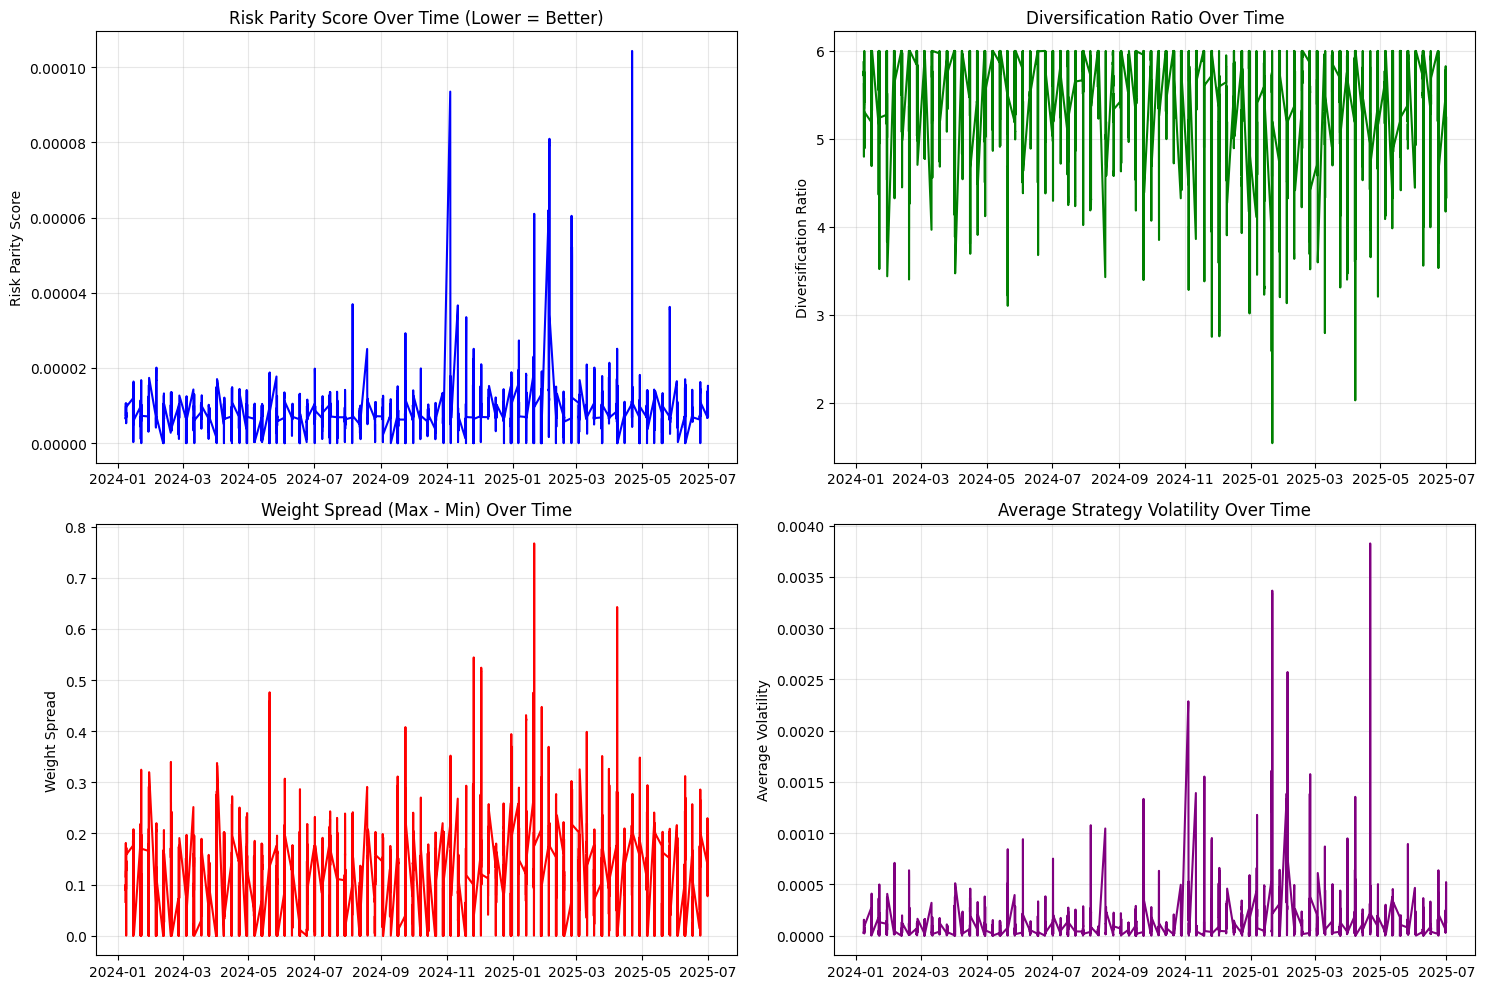


📊 Prime 10 ottimizzazioni:


In [12]:
# Analisi dei risultati dell'ottimizzazione Risk Parity
print("=== ANALISI OTTIMIZZAZIONE RISK PARITY ===")

if risk_parity_info:
    # Converti le informazioni in DataFrame per analisi
    opt_analysis = []
    for info in risk_parity_info:
        opt_analysis.append({
            'date': info['date'],
            'lookback_days': info['lookback_days'],
            'risk_parity_score': info['risk_parity_score'],
            'diversification_ratio': info['diversification_ratio'],
            'max_weight': info['max_weight'],
            'min_weight': info['min_weight'],
            'weight_spread': info['max_weight'] - info['min_weight'],
            'avg_volatility': np.mean(info['volatilities']),
            'vol_dispersion': np.std(info['volatilities'])
        })
    
    opt_df = pd.DataFrame(opt_analysis)
    
    print(f"\nStatistiche delle ottimizzazioni:")
    print(f"Risk Parity Score medio: {opt_df['risk_parity_score'].mean():.6f} (minore = migliore)")
    print(f"Diversification Ratio medio: {opt_df['diversification_ratio'].mean():.2f}")
    print(f"Peso massimo medio: {opt_df['max_weight'].mean():.2%}")
    print(f"Peso minimo medio: {opt_df['min_weight'].mean():.2%}")
    print(f"Spread pesi medio: {opt_df['weight_spread'].mean():.2%}")
    print(f"Volatilità media: {opt_df['avg_volatility'].mean():.4f}")
    
    # Visualizza evoluzione delle metriche Risk Parity
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Risk Parity Score nel tempo (minore = migliore)
    axes[0, 0].plot(opt_df['date'], opt_df['risk_parity_score'], 'b-')
    axes[0, 0].set_title('Risk Parity Score Over Time (Lower = Better)')
    axes[0, 0].set_ylabel('Risk Parity Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Diversification Ratio nel tempo
    axes[0, 1].plot(opt_df['date'], opt_df['diversification_ratio'], 'g-')
    axes[0, 1].set_title('Diversification Ratio Over Time')
    axes[0, 1].set_ylabel('Diversification Ratio')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Spread dei pesi (Max - Min)
    axes[1, 0].plot(opt_df['date'], opt_df['weight_spread'], 'r-')
    axes[1, 0].set_title('Weight Spread (Max - Min) Over Time')
    axes[1, 0].set_ylabel('Weight Spread')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Volatilità media delle strategie
    axes[1, 1].plot(opt_df['date'], opt_df['avg_volatility'], 'purple')
    axes[1, 1].set_title('Average Strategy Volatility Over Time')
    axes[1, 1].set_ylabel('Average Volatility')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostra le prime ottimizzazioni
    print("\n📊 Prime 10 ottimizzazioni:")
    display_df = opt_df.head(10)[['date', 'risk_parity_score', 'diversification_ratio', 'max_weight', 'min_weight']]
    display_df
    
else:
    print("⚠️ Nessuna informazione di ottimizzazione disponibile")
    print("Probabilmente la finestra di lookback è troppo grande per i dati disponibili")

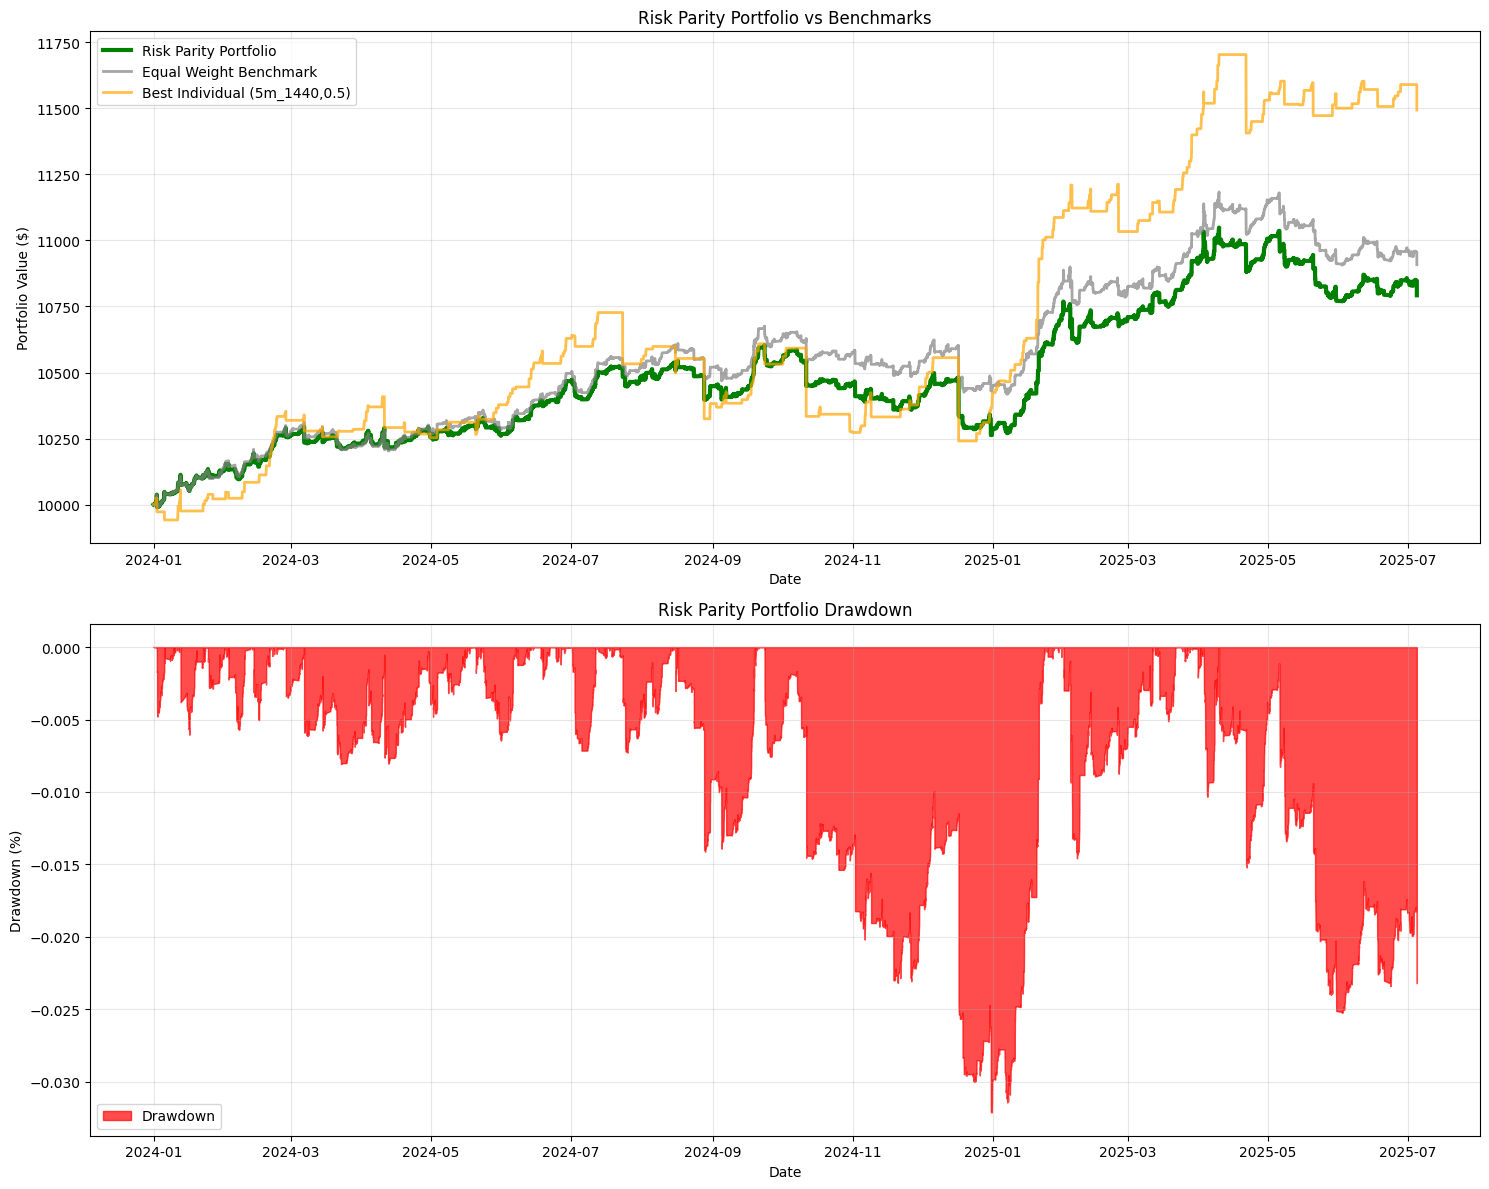


=== PERFORMANCE STATISTICS ===
Risk Parity Portfolio:
  Rendimento totale: 7.93%
  Max drawdown: -3.21%
  Valore finale: $10,792.52

Equal Weight Benchmark:
  Rendimento totale: 9.08%

Outperformance: -1.06%
Numero di ribilanciamenti: 3841
Sharpe ratio (approssimativo): 8.516


In [13]:
# Visualizzazione equity curve e confronto con benchmark
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Equity curve
axes[0].plot(risk_parity_portfolio['DATE'], risk_parity_portfolio['PORTFOLIO_VALUE'], 
             linewidth=3, color='green', label='Risk Parity Portfolio')

# Benchmark equal-weight
benchmark_weights = np.array([1/len(balance_cols)] * len(balance_cols))
benchmark_returns = []
returns_df = merged_ffill[balance_cols].pct_change().fillna(0)

for i in range(len(merged_ffill)):
    if i == 0:
        benchmark_returns.append(INITIAL_PORTFOLIO_VALUE)
    else:
        benchmark_return = np.sum(benchmark_weights * returns_df.iloc[i].values)
        benchmark_returns.append(benchmark_returns[-1] * (1 + benchmark_return))

axes[0].plot(merged_ffill['DATE'], benchmark_returns, 
             linewidth=2, color='gray', alpha=0.7, label='Equal Weight Benchmark')

# Best individual strategy
best_individual = merged_ffill[balance_cols].iloc[-1] / merged_ffill[balance_cols].iloc[0] * INITIAL_PORTFOLIO_VALUE
best_strategy = best_individual.idxmax()
axes[0].plot(merged_ffill['DATE'], merged_ffill[best_strategy] / merged_ffill[best_strategy].iloc[0] * INITIAL_PORTFOLIO_VALUE, 
             linewidth=2, color='orange', alpha=0.7, 
             label=f'Best Individual ({best_strategy.replace("BALANCE_", "").replace("usdcad_", "")})')

axes[0].set_title('Risk Parity Portfolio vs Benchmarks')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Drawdown
risk_parity_portfolio['PEAK'] = risk_parity_portfolio['PORTFOLIO_VALUE'].cummax()
risk_parity_portfolio['DRAWDOWN'] = (risk_parity_portfolio['PORTFOLIO_VALUE'] - risk_parity_portfolio['PEAK']) / risk_parity_portfolio['PEAK']

axes[1].fill_between(risk_parity_portfolio['DATE'], risk_parity_portfolio['DRAWDOWN'], 0, 
                    alpha=0.7, color='red', label='Drawdown')
axes[1].set_title('Risk Parity Portfolio Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche di performance
print("\n=== PERFORMANCE STATISTICS ===")
print(f"Risk Parity Portfolio:")
print(f"  Rendimento totale: {(risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"  Max drawdown: {risk_parity_portfolio['DRAWDOWN'].min():.2%}")
print(f"  Valore finale: ${risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")

print(f"\nEqual Weight Benchmark:")
benchmark_return = (benchmark_returns[-1]/INITIAL_PORTFOLIO_VALUE - 1)
print(f"  Rendimento totale: {benchmark_return:.2%}")

print(f"\nOutperformance: {((risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]) - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(risk_parity_rebal_dates)}")

# Calcola Sharpe ratio (approssimativo)
rp_returns = risk_parity_portfolio['PORTFOLIO_VALUE'].pct_change().dropna()
rp_sharpe = rp_returns.mean() / rp_returns.std() * np.sqrt(252*24*60) if rp_returns.std() > 0 else 0
print(f"Sharpe ratio (approssimativo): {rp_sharpe:.3f}")

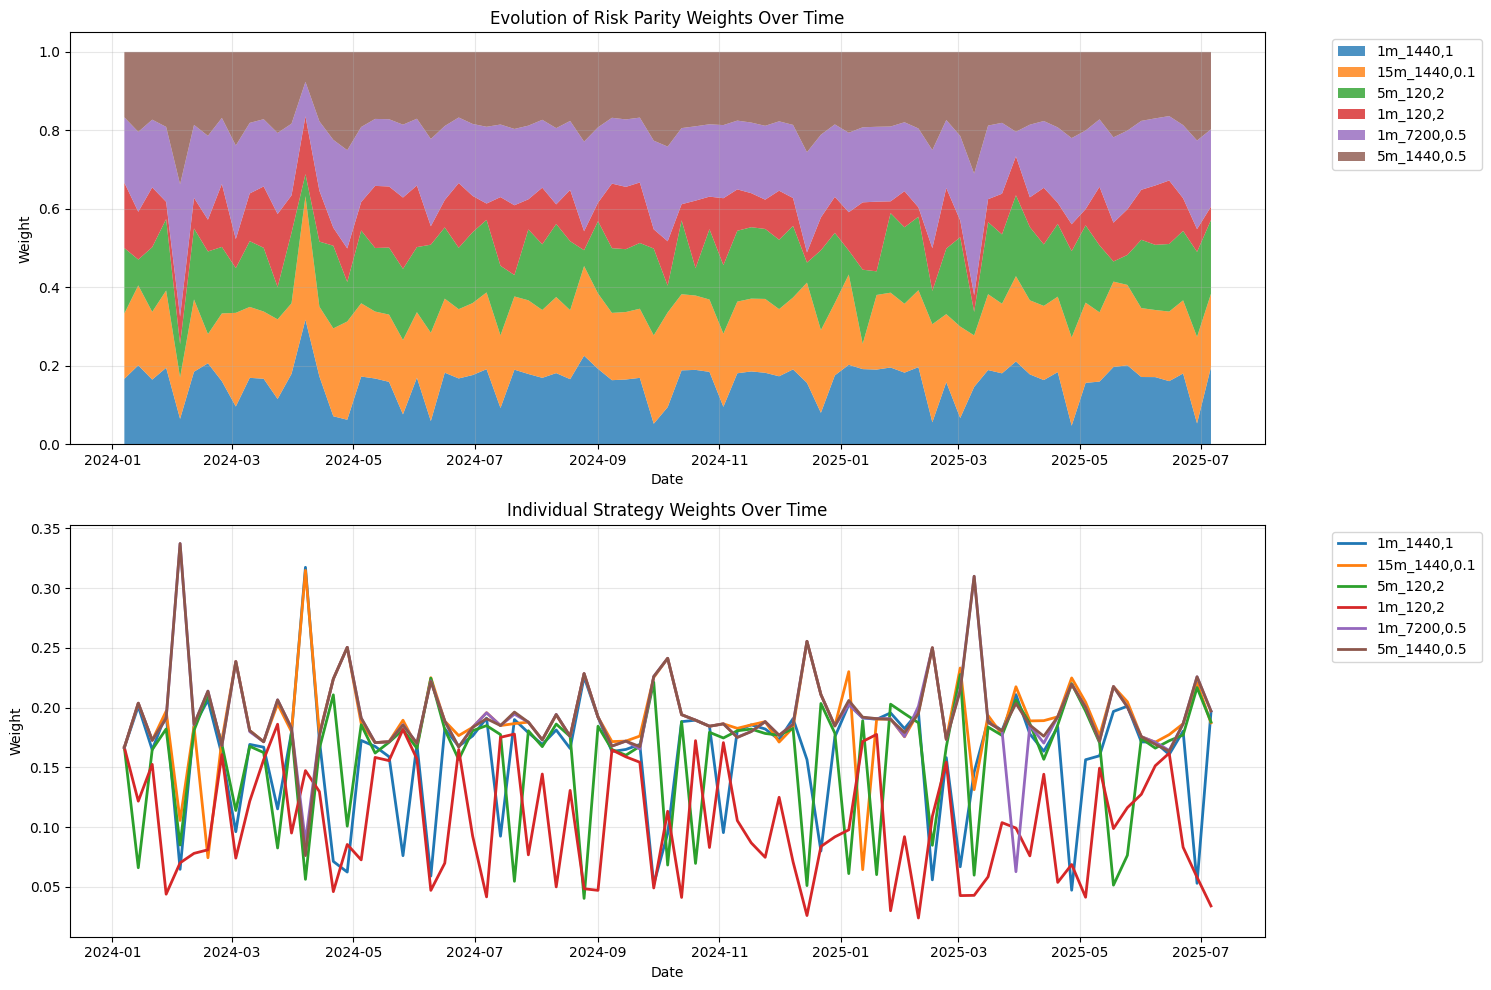


=== RISK CONTRIBUTION ANALYSIS ===

Pesi finali e contributi di rischio:
1m_1440,1: 19.50% (vol: 0.0009, risk contrib: 0.000179)
15m_1440,0.1: 19.50% (vol: 0.0032, risk contrib: 0.000629)
5m_120,2: 19.50% (vol: 0.0000, risk contrib: 0.000000)
1m_120,2: 2.49% (vol: 0.0000, risk contrib: 0.000000)
1m_7200,0.5: 19.50% (vol: 0.0038, risk contrib: 0.000735)
5m_1440,0.5: 19.50% (vol: 0.0037, risk contrib: 0.000725)

📊 RISK PARITY QUALITY:
Risk Parity Score finale: 0.000326 (minore = migliore)
Contributo di rischio medio: 0.000378
Deviazione standard contributi: 0.000326

🎯 RISK PARITY PORTFOLIO SUMMARY:
✅ Implementato controllo rigoroso anti-lookahead bias
✅ Ottimizzazione basata su Equal Risk Contribution
✅ Ribilanciamento settimanale con vincoli sui pesi
✅ Rendimento: 7.93%
✅ Max Drawdown: -3.21%
✅ Diversificazione: focus sulla gestione del rischio


In [14]:
# Analisi dell'evoluzione dei pesi Risk Parity
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Prepara dati per visualizzazione
weights_for_plot = risk_parity_weights.copy()
weights_for_plot.columns = [col.replace('BALANCE_', '').replace('usdcad_', '') for col in weights_for_plot.columns]
weights_weekly = weights_for_plot.resample('W').mean().fillna(method='ffill')

# 1. Stacked area chart
weights_data = []
for col in weights_weekly.columns:
    weights_data.append(weights_weekly[col].values)

axes[0].stackplot(weights_weekly.index, *weights_data, 
                 labels=weights_weekly.columns, alpha=0.8)
axes[0].set_title('Evolution of Risk Parity Weights Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Line chart
for col in weights_weekly.columns:
    axes[1].plot(weights_weekly.index, weights_weekly[col], label=col, linewidth=2)

axes[1].set_title('Individual Strategy Weights Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi dei contributi di rischio
print("\n=== RISK CONTRIBUTION ANALYSIS ===")
final_weights = risk_parity_weights.iloc[-1]
returns_df = merged_ffill[balance_cols].pct_change().fillna(0)
final_volatilities = returns_df.iloc[-LOOKBACK_WINDOW:].std()

print("\nPesi finali e contributi di rischio:")
for i, col in enumerate(balance_cols):
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    weight = final_weights[col]
    volatility = final_volatilities[col]
    risk_contribution = weight * volatility
    print(f"{strategy_name}: {weight:.2%} (vol: {volatility:.4f}, risk contrib: {risk_contribution:.6f})")

# Verifica della parità di rischio
risk_contributions = final_weights.values * final_volatilities.values
risk_parity_score = np.std(risk_contributions)
print(f"\n📊 RISK PARITY QUALITY:")
print(f"Risk Parity Score finale: {risk_parity_score:.6f} (minore = migliore)")
print(f"Contributo di rischio medio: {np.mean(risk_contributions):.6f}")
print(f"Deviazione standard contributi: {np.std(risk_contributions):.6f}")

print(f"\n🎯 RISK PARITY PORTFOLIO SUMMARY:")
print(f"✅ Implementato controllo rigoroso anti-lookahead bias")
print(f"✅ Ottimizzazione basata su Equal Risk Contribution")
print(f"✅ Ribilanciamento settimanale con vincoli sui pesi")
print(f"✅ Rendimento: {(risk_parity_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"✅ Max Drawdown: {risk_parity_portfolio['DRAWDOWN'].min():.2%}")
print(f"✅ Diversificazione: focus sulla gestione del rischio")